In [1]:
import qiskit as qk
import qinfer as qf
from qiskit.aqua.algorithms.single_sample import IQPE,QPE
from qiskit.aqua.components import iqfts
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.algorithms import ExactEigensolver
from qiskit.aqua.components.initial_states import Custom
import numpy as np
from qiskit import Aer,execute
from qiskit.aqua import QuantumInstance
# We need distributions to model priors.
from qinfer import distributions
# The noisy coin model has already been implmented, so let's import it here.
from qinfer.test_models import NoisyCoinModel
# Next, we need to import the sequential Monte Carlo updater class.
from qinfer.smc import SMCUpdater
# We'll be demonstrating approximate likelihood evaluation (ALE) as well.
from qinfer import ale
from qinfer import FiniteOutcomeModel
import matplotlib.pyplot as plt
from scipy.stats import circmean
import time

In [2]:
EPS = 1e-15
def chop(value):
    if np.abs(value) <= EPS:
        return 0
    else:
        return value

In [3]:
def radiandiff(a,b):
    FULL_ROTATION = 2 * np.pi
    return np.min(np.abs([a - b, b - a, a - b + FULL_ROTATION, b - a + FULL_ROTATION]))

# IQPE on ZZ Unitary with specified phase

In [4]:
# Set-up unitary with specified phase
angle = np.pi / 3
real = chop(np.real(np.exp(1.j * angle)))
imag = chop(np.imag(np.exp(1.j * angle)))

PAULI_DICT_ZZ = {
    'paulis': [
        {"coeff": {"imag": imag, "real": real}, "label": "ZZ"}
    ]
}
QUBIT_OP_ZZ = WeightedPauliOperator.from_dict(PAULI_DICT_ZZ)
eigen_results = ExactEigensolver(QUBIT_OP_ZZ,4).run()
eigen_value = eigen_results['eigvals'][0]
eigen_vector = eigen_results['eigvecs'][0]

In [5]:
print('Eigenvalues',eigen_results['eigvals'])
print('Phase is %.4f radians' %(angle))

Eigenvalues [-0.5-0.8660254j -0.5-0.8660254j  0.5+0.8660254j  0.5+0.8660254j]
Phase is 1.0472 radians


In [6]:
# Setup initial state as eigenvector
state_in = Custom(QUBIT_OP_ZZ.num_qubits, state_vector=eigen_vector)

In [7]:
# Use QASM Simulator for testing
simulator = Aer.get_backend('qasm_simulator')

In [8]:
# Construct IQPE circuit and simulate
iqpe_builder = IQPE(
    QUBIT_OP_ZZ,
    state_in,
    num_iterations=1,
    num_time_slices=1,
    expansion_mode='suzuki',
    expansion_order=1,
    shallow_circuit_concat=True)

# This is required to setup iqpe_builder so we can call construct_circuit() later on
iqpe_results = iqpe_circ = iqpe_builder.run(simulator,shots=1)

# QInfer Models and Definitions

In [9]:
class IQPEModel(FiniteOutcomeModel):
    
    def __init__(self):
        super(IQPEModel, self).__init__()

    ## PROPERTIES ##

    @property
    def n_modelparams(self):
        # phi
        return 1 # one for just phi, two for phi and T2

    @property
    def expparams_dtype(self):
        return [('theta','float64'), ('m','int64')]

    @property
    def is_n_outcomes_constant(self):
        return True

    ## METHODS ##

    @staticmethod
    def are_models_valid(modelparams):
        # NOTE: If T2 is included as a model parameter, restrict it to positive
        return np.logical_and(modelparams[:] >= 0, modelparams[:]<=2*np.pi).all(axis=1)

    def n_outcomes(self, expparams):
        return 2

    def likelihood(self, outcomes, modelparams, expparams):
        # We first call the superclass method, which basically
        # just makes sure that call count diagnostics are properly
        # logged.
        super(IQPEModel, self).likelihood(outcomes, modelparams, expparams)
        # Probability of getting 0 for IQPE is
        # P(0) = (1 + cos(M(theta - phi)))/2
#         pr0 = np.exp(-expparams['m'] / expparams['T2']) * (1 + np.cos(expparams['m'] * (expparams['theta'] - modelparams[:]))) / 2 + (1 - np.exp(-expparams['m'] / expparams['T2']))/2
        pr0 = (1 + np.cos(expparams['m'] * (expparams['theta'] - modelparams[:]))) / 2

        # Concatenate over outcomes.
        return FiniteOutcomeModel.pr0_to_likelihood_array(outcomes, pr0)

In [10]:
class PhaseSMCUpdater(SMCUpdater):
    @staticmethod
    def particle_mean(weights,locations):
        weighted_values = np.multiply(weights, locations)
        return circmean(weighted_values)

In [11]:
N_PARTICLES = 5000
N_EXP = 20
USE_QISKIT_QASM_SIMULATOR = False
SIM_N_SHOTS=4096

performance_dtype = [
    ('outcome', 'i1'),
    ('est_mean', 'f8'), ('est_cov_mat', 'f8'),
    ('true_err', 'f8'), ('resample_count', 'i8'),
    ('elapsed_time', 'f8'),
    ('like_count', 'i8'), ('sim_count', 'i8'),
    ('bme', 'f8'),
    ('var', 'f8'),
    ('bme_err', 'f8')
]
performance = np.empty((N_EXP), dtype=performance_dtype)

In [12]:
# Set-up initial prior and QInfer model
prior = distributions.UniformDistribution([0, 2 * np.pi])
# prior = distributions.NormalDistribution(np.pi,0.5)
model = IQPEModel()

# Set-up initial experimental parameters
THETA = prior.sample()[0][0]
M = 3

In [13]:
data_backend = Aer.get_backend('qasm_simulator')

In [21]:
# Create a Bayesian Inference Updater
updater = PhaseSMCUpdater(model, N_PARTICLES, prior)

# For each experiment we defined earlier
for idx_exp in range(N_EXP):
    # Define experimental parameters
    expparams = np.array([(M,THETA)], dtype=model.expparams_dtype)
    
    # Simulate IQPE circuit and get results for inference
    circuit = iqpe_builder.construct_circuit(k=M,omega=THETA,measurement=True)
    results = execute(circuit,simulator,shots=SIM_N_SHOTS,memory=True)
    counts = results.result().get_counts()
    memory = results.result().get_memory()

    # Start by simulating and recording the data.

    # Retrieve the outcome of the simulation either from the circuit simulation or a model simulation
    if USE_QISKIT_QASM_SIMULATOR:
        outcomes = np.array([[int(m) for m in memory]])
    else:
        outcomes = model.simulate_experiment(np.array([[angle]]),expparams,repeat=SIM_N_SHOTS)
        outcomes = outcomes.reshape((1,outcomes.shape[0]))
        
#     performance['outcome'][idx_exp] = [outcomes]

    # Reset the like_count and sim_count
    # properties so that we can count how many were used
    # by this update. Note that this is a hack;
    # an appropriate method should be added to
    # Simulatable.
    model._sim_count = 0
    model._call_count = 0

    # Time the update process
    #     tic = toc = None
    #     tic = time.time()

    # Update the posterior particles using the result of the circuit simulation
    updater.batch_update(outcomes, expparams)
    
    #     performance[idx_exp]['elapsed_time'] = time.time() - tic

    # Record the performance of this updater.
    est_mean = updater.est_mean()
    performance[idx_exp]['est_mean'] = est_mean
    performance[idx_exp]['true_err'] = radiandiff(est_mean,angle) ** 2
    performance[idx_exp]['est_cov_mat'] = updater.est_covariance_mtx()
    performance[idx_exp]['resample_count'] = updater.resample_count
    performance[idx_exp]['like_count'] = model.call_count
    performance[idx_exp]['sim_count'] = model.sim_count
    
    
    # Re-evaluate experiment parameters
    uniform_draw_01 = np.random.uniform()
    cumsum_particles = np.cumsum(updater.particle_weights)
    draw_index = (cumsum_particles<= uniform_draw_01).argmin()
    THETA = updater.particle_locations[draw_index]
    current_variance = updater.est_covariance_mtx()[0][0]

    # M modification scheme
    min_M = 8 - int(np.mod(idx_exp,10)/2)
#     min_M = 4
    M = int(np.max([min_M,np.ceil(1.25/np.sqrt(current_variance))]))
    print(min_M,M,THETA)

print('Inference completed')

8 8 [2.36650238]
8 8 [5.22068271]
7 7 [3.97986946]
7 7 [4.90613667]
6 6 [0.84386352]
6 6 [0.93734847]
5 5 [2.21813414]
5 5 [1.14493803]
4 4 [2.57260678]
4 4 [1.08745655]
8 8 [1.07304388]
8 8 [1.05625576]
7 7 [0.92923053]
7 7 [0.95920369]
6 6 [1.09388581]
6 6 [0.91580722]
5 5 [0.84284647]
5 5 [0.88393934]
4 4 [1.1123921]
4 4 [0.97971561]
Inference completed


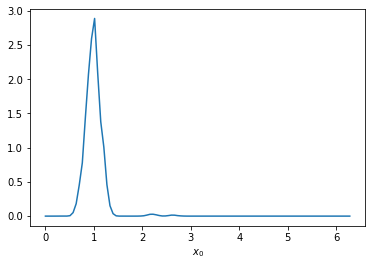

In [22]:
plot = updater.plot_posterior_marginal()